adapted from EECS 442 PS7: Object Detection



# Single-Stage Object Detector

You will be implementing parts of a single stage object detector closely related to [`YOLOv1`](https://arxiv.org/pdf/1506.02640.pdf) in this problem set. We will also evaluate the detection accuracy using the classic metric mean Average Precision ([`mAP`](https://github.com/Cartucho/mAP)).

We recommend you take a look at the paper linked above or feel free to take a look at this comprehensive [`summary`](https://towardsdatascience.com/yolov1-you-only-look-once-object-detection-e1f3ffec8a89) of the paper by Sik-Ho Tsang.

**Wait a minute!! Before you begin... Check this cool video of YOLOv1 object detector watching sports: [`Video here`](https://youtu.be/Gl1rxvEvgEs)**



# Setup

Run the following code to import the modules you'll need. After your finish the assignment, remember to run all cells and save the note book as PDF (according to directions in the problem set) and submit the PDF file to Gradescope.

In [125]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [126]:
!pip install git+https://github.com/deepvision-class/starter-code

  Cloning https://github.com/deepvision-class/starter-code to /tmp/pip-req-build-airbjf_3
  Running command git clone -q https://github.com/deepvision-class/starter-code /tmp/pip-req-build-airbjf_3
  Created wheel for Colab-Utils: filename=Colab_Utils-0.1.dev0-cp36-none-any.whl size=10324 sha256=f58e40ed58bf7383dad830df0ce60a3869377d21d8c5b9726d2466344e533e7d
  Stored in directory: /tmp/pip-ephem-wheel-cache-h9ulanhh/wheels/63/d1/27/a208931527abb98d326d00209f46c80c9d745851d6a1defd10
Successfully built Colab-Utils


In [127]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import coutils
from coutils import extract_drive_file_id, register_colab_notebooks, \
                    fix_random_seed, rel_error
from torch.utils.data import Dataset, DataLoader, Subset
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import cv2
import copy
import time
import shutil
import os

# for plotting
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# data type and device for torch.tensor
to_float = {'dtype': torch.float, 'device': 'cpu'}
to_float_cuda = {'dtype': torch.float, 'device': 'cuda'}
to_double = {'dtype': torch.double, 'device': 'cpu'}
to_double_cuda = {'dtype': torch.double, 'device': 'cuda'}
to_long = {'dtype': torch.long, 'device': 'cpu'}
to_long_cuda = {'dtype': torch.long, 'device': 'cuda'}

# for mAP evaluation
!rm -rf mAP
!git clone https://github.com/Cartucho/mAP.git
!rm -rf mAP/input/*

Cloning into 'mAP'...
remote: Enumerating objects: 908, done.
remote: Total 908 (delta 0), reused 0 (delta 0), pack-reused 908
Receiving objects: 100% (908/908), 14.71 MiB | 39.02 MiB/s, done.
Resolving deltas: 100% (321/321), done.


We will use GPUs to accelerate our computation in this notebook. Run the following to make sure GPUs are enabled:

In [128]:
if torch.cuda.is_available():
  print('Good to go!')
else:
  print('Please set GPU via Edit -> Notebook Settings.')

Good to go!


# Load ExtremeWeather dataset

### Images 
shape: $1152 \times 768$

### Bounding Boxes and Labels
shape: $15 \times 5$

<!-- 
Unlike the CIFAR-10 and the MiniPlaces dataset we used in previous problem sets for image classificaiton, PASCAL VOC is one of the standard datasets used for object detection.

Object detection datasets provide images which are annotated with a set of bounding boxes, where each box gives the category label and spatial extent of some object present in the image.

We will use the [`PASCAL VOC 2007`](http://host.robots.ox.ac.uk/pascal/VOC/) dataset, which provides annotations of this form. PASCAL VOC ran a series of yearly computer vision competitions from 2005 to 2012, predating the ImageNet challenge for image classification.

The data from the 2007 challenge used to be one of the most popular datasets for evaluating object detection. It is much smaller than more recent object detection datasets such as [`COCO`](http://cocodataset.org/#home), and thus easier to manage in a problem set.

The following function will download the PASCAL VOC 2007 dataset and return it as a PyTorch Dataset object: -->





In [129]:
def min_max_norm(arr, channel):
  if channel == 2:
    MAX = 1.0867410e05
    MIN = 9.0560906e04
  elif channel == 6:
    MAX = 9.5626381e01
    MIN = 3.2156777e-02
  else: # if channel == 8
    MAX = 3.3686847e02
    MIN = 1.5234143e02

  return np.divide(np.subtract(arr, MIN), MAX - MIN)

In [130]:
def downsample_upsample(arr):
  r = 8
  # downsample first -- bilinear interpolation
  LR = cv2.resize(arr, (1152//r, 768//r))
  # upsample after -- bicubic interpolation
  HR = cv2.resize(LR, (1152, 768), interpolation=cv2.INTER_CUBIC)
  return torch.tensor(HR).unsqueeze(2)

### Dataset Class

In [131]:
class ExtremeWeatherDataset(Dataset):
  def __init__(self):
      self.PATH_2 = 'drive/My Drive/ProjectX 2020/Data/1979/2/CycleGAN_Data/ExtremeWeather'
      self.PATH_6 = 'drive/My Drive/ProjectX 2020/Data/1979/6'
      self.PATH_8 = 'drive/My Drive/ProjectX 2020/Data/1979/8'
      self.PATH_LABEL = 'drive/My Drive/ProjectX 2020/Data/1979/1979_boxes.npy'
      self.NUMBER = 1460

  def __len__(self):
    return self.NUMBER

  def __getitem__(self, idx): 
    # load images ==============================================================================================================
    images = []
    for channel_2, channel_6, channel_8 in zip([os.listdir(self.PATH_2)[idx]], 
                                               [os.listdir(self.PATH_6)[idx]], 
                                               [os.listdir(self.PATH_8)[idx]]):
      image_path_2, image_path_6, image_path_8 = os.path.join(self.PATH_2, channel_2), \
                                                 os.path.join(self.PATH_6, channel_6), \
                                                 os.path.join(self.PATH_8, channel_8)
      image_2, image_6, image_8 = downsample_upsample(min_max_norm(np.load(image_path_2), 2)), \
                                  downsample_upsample(min_max_norm(np.load(image_path_6), 6)), \
                                  downsample_upsample(min_max_norm(np.load(image_path_8), 8))
      images.append(torch.cat([image_2, image_6, image_8], dim=2))
      del image_2; del image_6; del image_8;
    images = torch.stack(images, dim=0).permute(0, 3, 1, 2).squeeze()
    # //////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

    # load bounding boxes and class labels =====================================================================================
    boxes_labels = torch.tensor(np.load(os.path.join(self.PATH_LABEL))[idx]).to(dtype=torch.float).reshape(-1, 15, 5)
    # SWITCH order of coordinates (y, x) --> (x, y)
    # print('before:', train_boxes_labels[9, 0])
    boxes_labels = torch.stack((boxes_labels[:, :, 1], 
                                boxes_labels[:, :, 0], 
                                boxes_labels[:, :, 3], 
                                boxes_labels[:, :, 2], 
                                boxes_labels[:, :, 4]),
                              dim=2).squeeze()
    # print('after:', train_boxes_labels[9, 0])
    # //////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
    return (images, boxes_labels)

In [132]:
def extreme_weather_loader(dataset, batch_size, num_workers, shuffle):
  loader = DataLoader(dataset,
                      batch_size=batch_size,
                      shuffle=shuffle, pin_memory=True,
                      num_workers=num_workers)
  return loader

In [133]:
dataset = ExtremeWeatherDataset()

train_dataset = Subset(dataset, torch.arange(0, 1260)) # use 1260 samples (~86.3%) for training
val_dataset = Subset(dataset, torch.arange(1260, 1460))

train_loader = extreme_weather_loader(train_dataset, 10, 0, True)
val_loader = extreme_weather_loader(val_dataset, 10, 0, False)

The `DataLoader` objects return batches of data.

The first output from the `DataLoader` is a Tensor `img` of shape `(B, 3, 768, 1152)`. This is a batch of `B` images, similar to what we have seen in classification datasets.

The second output from the `DataLoader` is a Tensor `ann` of shape `(B, N, 5)` giving information about all objects in all images of the batch. `ann[i, j] = (x_tl, y_tl, x_br, y_br, class)` gives information about the `j`th object in `img[i]`. The position of the top-left corner of the box is `(x_tl, y_tl)` and the position of the bottom-right corner of the box is `(x_br, y_br)`. These positions are in the coordinate system of the original image (no resizing is done). `class` is an integer giving the category label for this bounding box.

Each image can have different numbers of objects. If `img[i]` has $N_i$ objects, then $N=\max_i N_i$ is the maximum number of objects per image among all objects in the batch; this value can vary from batch to batch. For the images that have fewer than $N$ annotated objects, only the first $N_i$ rows of `ann[i]` contain annotations; the remaining rows are padded with -1.

In [134]:
train_loader_iter = iter(train_loader)
img, ann = train_loader_iter.next()

print('img has shape:', img.shape)
print('ann has shape:', ann.shape)

print('Image 1 has only four annotated objects, so ann[1] is padded with -1:')
print(ann[1])

print('\nEach row in the annotation tensor indicates (x_tl, y_tl, x_br, y_br, class).')

img has shape: torch.Size([10, 3, 768, 1152])
ann has shape: torch.Size([10, 15, 5])
Image 1 has only four annotated objects, so ann[1] is padded with -1:
tensor([[476.,  55., 556., 135.,   2.],
        [625., 193., 705., 273.,   2.],
        [ -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.]])

Each row in the annotation tensor indicates (x_tl, y_tl, x_br, y_br, class).


# Coordinate transformation
It's a good practice to use a consistent coordinate system for all the spatial-related computations (e.g., bboxes or proposals). In this problem set, **we use the coordinate system defined by the CNN activation map (of shape $36 \times 24$), where the top-left corner is $(0, 0)$ and the bottom-right corner is $(36, 24)$. The horizontal axis is the x axis and the vertical axis is the y axis.**

The following function defines the transformation from the original image coordinate system (pixels, and the top-left corner is $(0, 0)$) to the activation map coordinate system and vice versa.

Notes: All the coordinates are in float precision. In later sections, **we use the activation map coordinate system for all computations except for visualization.**

In [135]:
def coord_trans(bbox, w_amap=36, h_amap=24, mode='a2p'):
  """
  Coordinate transformation function. It converts the box coordinate from
  the image coordinate system to the activation map coordinate system and vice versa.
  In our case, the input image will have a few hundred of pixels in
  width/height while the activation map is of size 36x24.

  Input:
  - bbox: Could be either bbox, anchor, or proposal, of shape Bx*x4
  # - w_pixel: Number of pixels in the width side of the original image, of shape B
  # - h_pixel: Number of pixels in the height side of the original image, of shape B
  - w_amap: Number of pixels in the width side of the activation map, scalar
  - h_amap: Number of pixels in the height side of the activation map, scalar
  - mode: Whether transfer from the original image to activation map ('p2a') or
          the opposite ('a2p')

  Output:
  - resized_bbox: Resized box coordinates, of the same shape as the input bbox
  """

  assert mode in ('p2a', 'a2p'), 'invalid coordinate transformation mode!'
  assert bbox.shape[-1] >= 4, 'the transformation is applied to the first 4 values of dim -1'

  B = bbox.shape[0]
  w_pixel = torch.full((B,), 1152.).to(bbox.device)
  h_pixel = torch.full((B,), 768.).to(bbox.device)
  
  if B == 0: # corner cases
    return bbox

  resized_bbox = bbox.clone()
  # could still work if the first dim of bbox is not batch size
  # in that case, w_pixel and h_pixel will be scalars
  resized_bbox = resized_bbox.view(bbox.shape[0], -1, bbox.shape[-1])
  invalid_bbox_mask = (resized_bbox == -1) # indicating invalid bbox

  if mode == 'p2a':
    # pixel to activation
    width_ratio = w_pixel * 1. / w_amap
    height_ratio = h_pixel * 1. / h_amap
    resized_bbox[:, :, [0, 2]] /= width_ratio.view(-1, 1, 1)
    resized_bbox[:, :, [1, 3]] /= height_ratio.view(-1, 1, 1)
  else:
    # activation to pixel
    width_ratio = w_pixel * 1. / w_amap
    height_ratio = h_pixel * 1. / h_amap
    # print("W,h ratios: ", width_ratio, height_ratio)
    # print(resized_bbox[0,0])
    resized_bbox[:, :, [0, 2]] *= width_ratio.view(-1, 1, 1)
    resized_bbox[:, :, [1, 3]] *= height_ratio.view(-1, 1, 1)

  # print("resized_bboxes 1: ", torch.min(resized_bbox), torch.max(resized_bbox))
  # print(resized_bbox[0,0])
  resized_bbox.masked_fill_(invalid_bbox_mask, -1)
  resized_bbox.resize_as_(bbox)
  # print("resized_bboxes 2: ", torch.min(resized_bbox), torch.max(resized_bbox))
  return resized_bbox

# Data Visualizer
This function will help us visualize boxes on top of images.

In [136]:
class_to_idx = {'tropical-depression': 0, 
                'tropical-cyclone': 1,
                'extratropical-cyclone': 2,
                'atmospheric-river': 3
}

idx_to_class = {i:c for c, i in class_to_idx.items()}

In [137]:
def data_visualizer(img, idx_to_class, bbox=None, pred=None):
  """
  Data visualizer on the original image. Support both GT box input and proposal input.
  
  Input:
  - img: PIL Image input
  - idx_to_class: Mapping from the index (0-19) to the class name
  - bbox: GT bbox (in red, optional), a tensor of shape Nx5, where N is
          the number of GT boxes, 5 indicates (x_tl, y_tl, x_br, y_br, class)
  - pred: Predicted bbox (in green, optional), a tensor of shape N'x6, where
          N' is the number of predictedboxes , 6 indicates
          (x_tl, y_tl, x_br, y_br, class, object confidence score)
  """
  img_copy = torch.stack([img, img, img], dim=-1)
  img_copy = np.array(img_copy)

  if bbox is not None:
    for bbox_idx in range(bbox.shape[0]):
      one_bbox = bbox[bbox_idx][:4]
      cv2.rectangle(img_copy, (one_bbox[0], one_bbox[1]), (one_bbox[2],
                  one_bbox[3]), (255, 0, 0), 2)
      if bbox.shape[1] > 4: # if class info provided
        obj_cls = idx_to_class[bbox[bbox_idx][4].item()]
        cv2.putText(img_copy, '%s' % (obj_cls),
                  (one_bbox[0], one_bbox[1]+15),
                  cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 255), thickness=2)

  if pred is not None:
    for bbox_idx in range(pred.shape[0]):
      one_bbox = pred[bbox_idx][:4]

      cv2.rectangle(img_copy, (one_bbox[0], one_bbox[1]), (one_bbox[2],
                  one_bbox[3]), (0, 255, 0), 2)
      
      if pred.shape[1] > 4: # if class and conf score info provided
        obj_cls = idx_to_class[pred[bbox_idx][4].item()]
        conf_score = pred[bbox_idx][5].item()
        cv2.putText(img_copy, '%s, %.2f' % (obj_cls, conf_score),
                    (one_bbox[0], one_bbox[1]+15),
                    cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 255), thickness=2)

  plt.imshow(img_copy)
  plt.axis('off')
  plt.show()

## Visualize ExtremeWeather
It is always good practice to try and visualize parts of your dataset before you build a model.

Here we sample some  images from the ExtremeWeather training set, and visualize the ground-truth object boxes and category labels:

In [138]:
# default examples for visualization
fix_random_seed(1)
batch_size = 3
sampled_idx = torch.linspace(0, len(train_dataset)-1, steps=batch_size).long()

# get the size of each image first
h_list = []
w_list = []
img_list = [] # list of images
MAX_NUM_BBOX = 15
box_list = []

for idx, i in enumerate(sampled_idx):
  img, ann = train_dataset.__getitem__(i)
  img_list.append(img)
  box_list.append(ann)

box_list = torch.stack(box_list, dim=0).to(ann.device)
resized_box_list = coord_trans(box_list, mode='p2a') # on activation map coordinate system

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


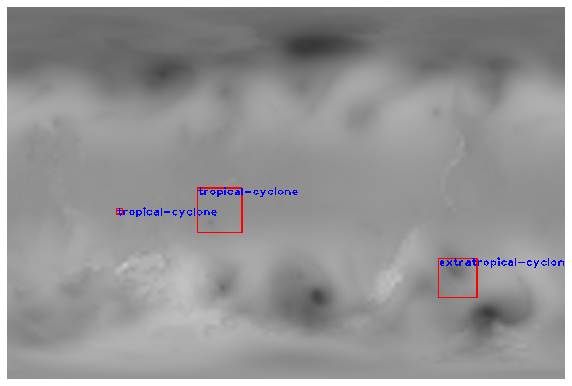

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


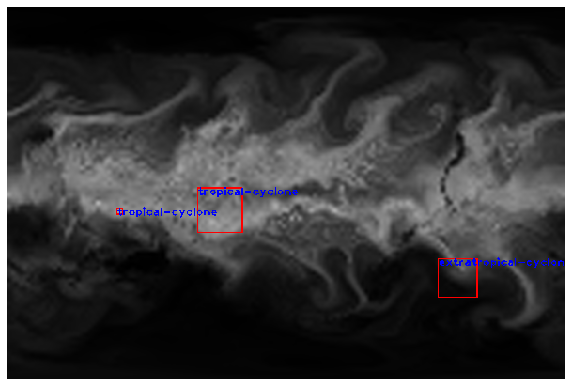

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


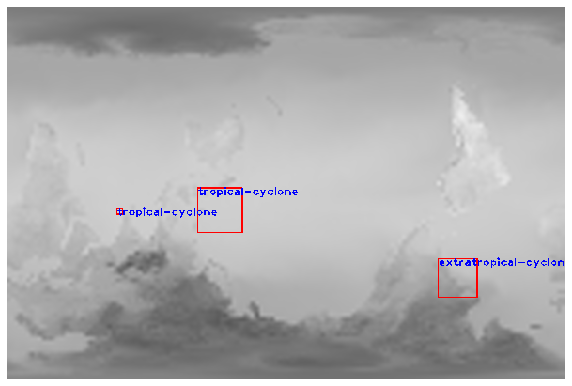

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


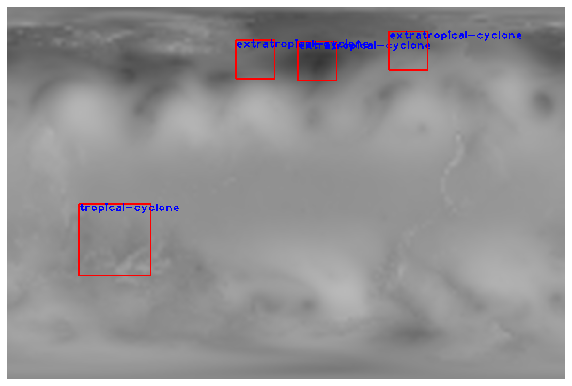

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


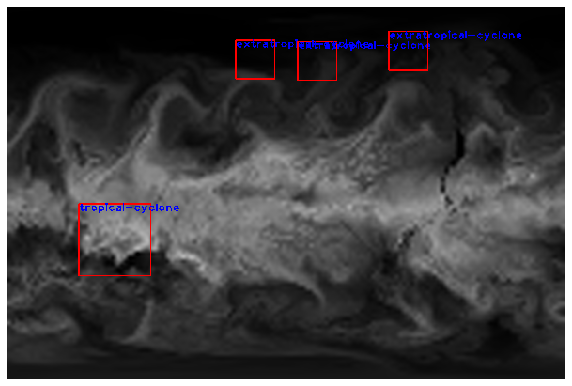

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


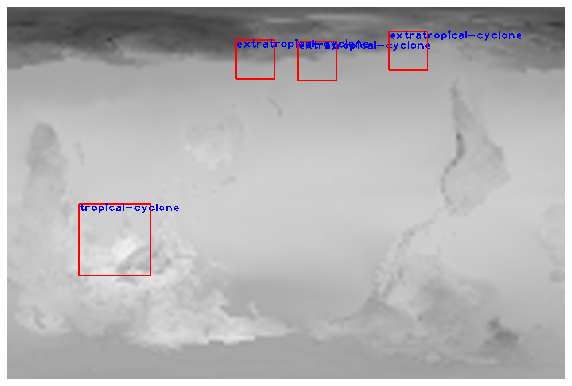

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


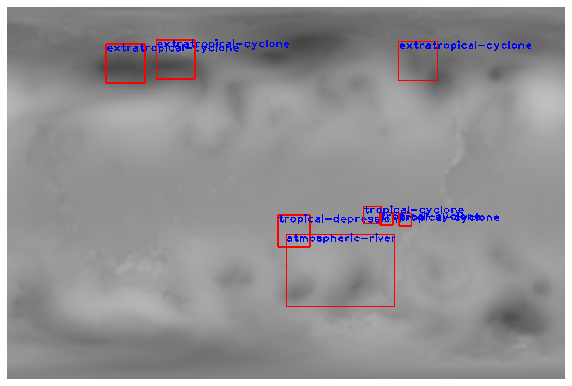

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


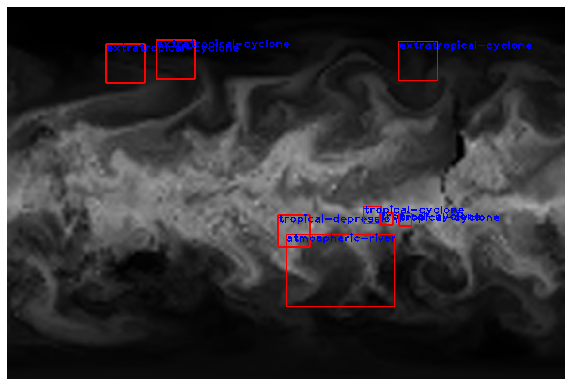

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


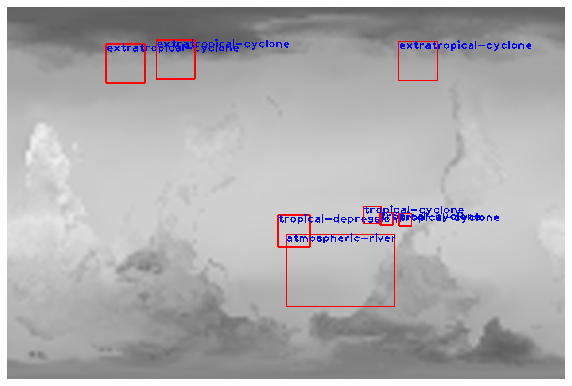

In [139]:
# visualize GT boxes on each channel, for each image
for i in range(len(img_list)):
  valid_box = sum([1 if j != -1 else 0 for j in box_list[i][:, 0]])
  for j in range(3):
    data_visualizer(img_list[i][j], idx_to_class, box_list[i][:valid_box])
  print('===================================================================')

# Detector Backbone Network
Here, we use a [MobileNet v2](https://pytorch.org/hub/pytorch_vision_mobilenet_v2/) for image feature extraction.

In [140]:
class FeatureExtractor(nn.Module):
  """
  Image feature extraction with MobileNet.
  """
  def __init__(self, reshape_x=1152, reshape_y=768, pooling=False, verbose=False):
    super().__init__()

    from torchvision import models
    from torchsummary import summary

    self.mobilenet = models.mobilenet_v2(pretrained=True)
    self.mobilenet = nn.Sequential(*list(self.mobilenet.children())[:-1]) # Remove the last classifier

    # average pooling
    if pooling:
      self.mobilenet.add_module('LastAvgPool', nn.AvgPool2d(math.ceil(reshape_size/32.))) # input: N x 1280 x 36 x 24

    for i in self.mobilenet.named_parameters():
      i[1].requires_grad = True # fine-tune all

    if verbose:
      summary(self.mobilenet.cuda(), (3, reshape_x, reshape_y))
  
  def forward(self, img, verbose=False):
    """
    Inputs:
    - img: Batch of resized images, of shape Nx3x224x224
    
    Outputs:
    - feat: Image feature, of shape Nx1280 (pooled) or Nx1280x7x7
    """
    num_img = img.shape[0]
    
    img_prepro = img

    feat = []
    process_batch = 500
    for b in range(math.ceil(num_img/process_batch)):
      feat.append(self.mobilenet(img_prepro[b*process_batch:(b+1)*process_batch]
                              ).squeeze(-1).squeeze(-1)) # forward and squeeze
    feat = torch.cat(feat)
    
    if verbose:
      print('Output feature shape: ', feat.shape)
    
    return feat

Now, let's see what's inside MobileNet v2. Assume we have a 3x224x224 image input.

In [141]:
model = FeatureExtractor(verbose=True)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 576, 384]             864
       BatchNorm2d-2         [-1, 32, 576, 384]              64
             ReLU6-3         [-1, 32, 576, 384]               0
            Conv2d-4         [-1, 32, 576, 384]             288
       BatchNorm2d-5         [-1, 32, 576, 384]              64
             ReLU6-6         [-1, 32, 576, 384]               0
            Conv2d-7         [-1, 16, 576, 384]             512
       BatchNorm2d-8         [-1, 16, 576, 384]              32
  InvertedResidual-9         [-1, 16, 576, 384]               0
           Conv2d-10         [-1, 96, 576, 384]           1,536
      BatchNorm2d-11         [-1, 96, 576, 384]             192
            ReLU6-12         [-1, 96, 576, 384]               0
           Conv2d-13         [-1, 96, 288, 192]             864
      BatchNorm2d-14         [-1, 96, 2

## Activation Grid Generator
After passing the input image through the backbone network, we have a convolutional feature map of shape $(D, 36, 24)$ which we interpret as a $36 \times 24$ grid of $D$-dimensional features. At each point in this grid, we predict a set of $A$ bounding boxes. The total number of bounding boxes we predict for a single image are thus $A \times 36 \times 24$. 

Centered at each position of the $36 \times 24$ activation grid, we predict $A$ bounding boxes, where $A = 2$ in our case. In order to place bounding boxes centered at each position of the $36 \times 24$ grid of backbone features, we need to know the spatial position of the center of each cell in the grid of features.

This function will compute these center coordinates for us.

In [142]:
def GenerateGrid(batch_size, w_amap=36, h_amap=24, dtype=torch.float32, device='cuda'):
  """
  Return a grid cell given a batch size (center coordinates).

  Inputs:
  - batch_size, B
  - w_amap: or W', width of the activation map (number of grids in the horizontal dimension)
  - h_amap: or H', height of the activation map (number of grids in the vertical dimension)
  - W' and H' are always 7 in our case while w and h might vary.
  
  Outputs:
  grid: A float32 tensor of shape (B, H', W', 2) giving the (x, y) coordinates
        of the centers of each feature for a feature map of shape (B, D, H', W')
  """
  w_range = torch.arange(0, w_amap, dtype=dtype, device=device) + 0.5
  h_range = torch.arange(0, h_amap, dtype=dtype, device=device) + 0.5
  w_grid_idx = w_range.unsqueeze(0).repeat(h_amap, 1)
  h_grid_idx = h_range.unsqueeze(1).repeat(1, w_amap)
  grid = torch.stack([w_grid_idx, h_grid_idx], dim=-1)
  grid = grid.unsqueeze(0).repeat(batch_size, 1, 1, 1)

  return grid

Visualize this grid for a few images and notice the red dot at the center of each grid cell, which is the reference point from where we will be predicting our bouding boxes. (Remember, we will predict $A = 2$ bounding boxes per grid cell).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


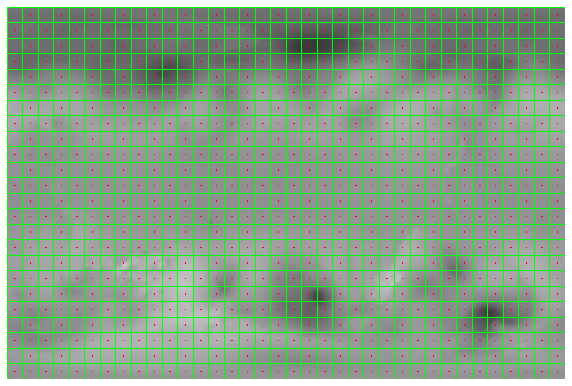

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


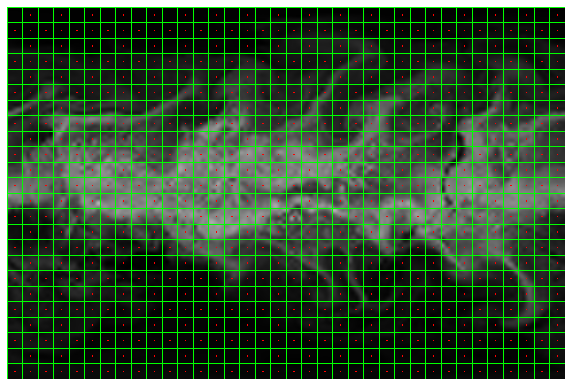

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


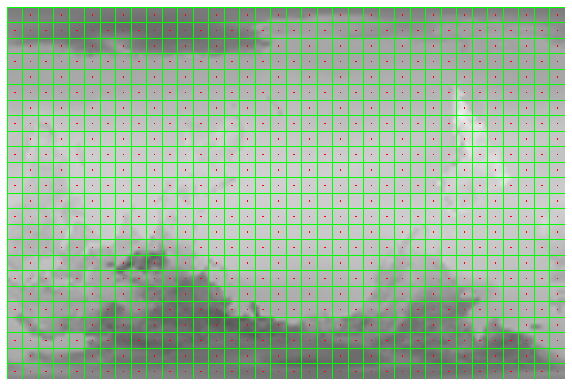

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


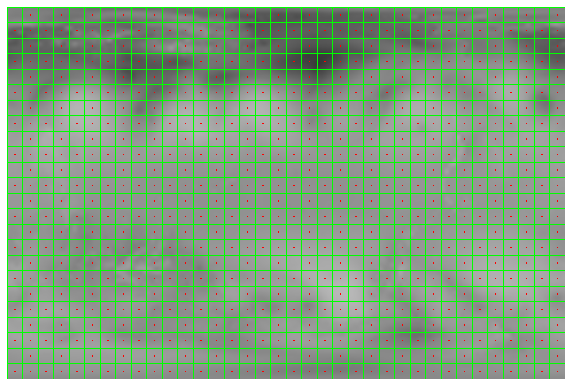

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


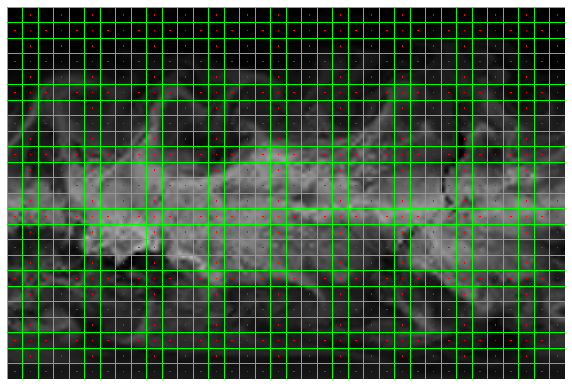

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


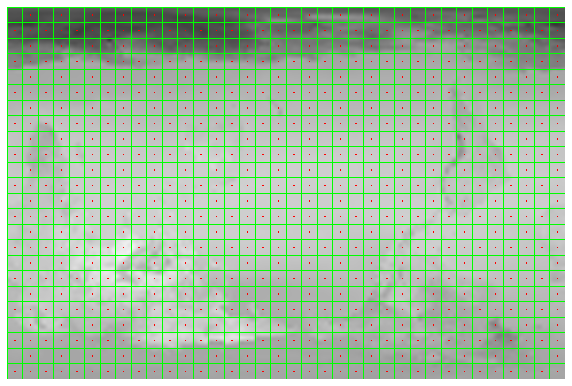

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


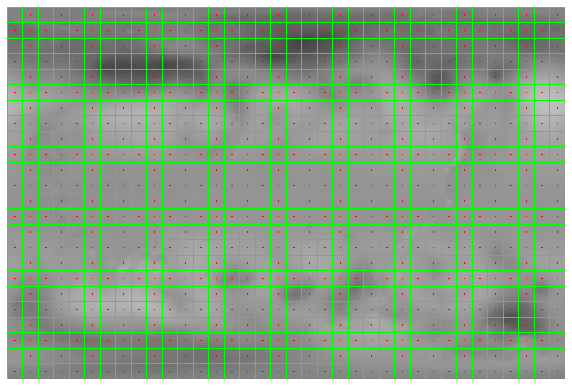

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


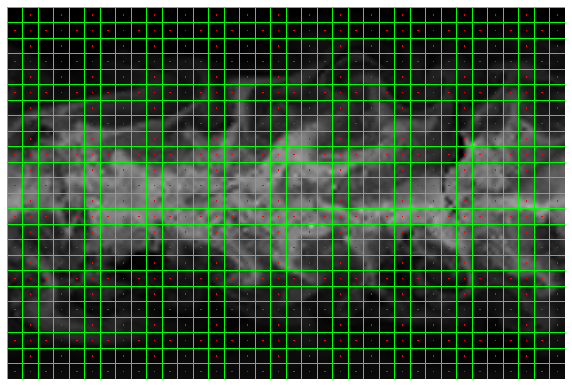

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


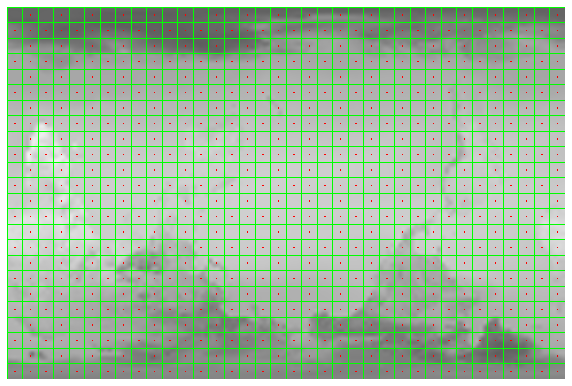

In [143]:
# visualization
# simply create an activation grid where the cells are in green and the centers in red
# you should see the entire image divided by a 36x24 grid, with no gaps on the edges

grid_list = GenerateGrid(box_list.shape[0])

center = torch.cat((grid_list, grid_list), dim=-1)
grid_cell = center.clone()
grid_cell[:, :, :, [0, 1]] -= 1. / 2.
grid_cell[:, :, :, [2, 3]] += 1. / 2.

center = coord_trans(center)
grid_cell = coord_trans(grid_cell)

for img, anc, grid in zip(img_list, center, grid_cell):
  for i in range(3):
    data_visualizer(img[i], idx_to_class, anc.reshape(-1, 4), grid.reshape(-1, 4))
  print('=======================================================================')

## 7.1 (2) Proposal Generator

Now, consider a grid with center, width and height $(x_c^g,y_c^g)$.
The Prediction Network, which you will implement later will predict *offsets* $(t^x, t^y, t^w, t^h)$; By applying this transformations we get the *bounding box or proposal* with center, width and height $(x_c^p,y_c^p,w^p,h^p)$. To convert the offsets to the actual bounding box/proposal parameters, use the below mentioned transformation formulas.

Notice here we parametrize the boxes in form `(x, y, w, h)`, where `x, y` represent the center coordinates, and `w, h` represent the width and height respectively. This is in contrast to the `(xtl, ytl, xbr, ybr)` parametrization 
for the GT bounding boxes. While writing functions and performing operations,
be mindful of which of these forms your bounding boxes are of. In this case,
even though we apply the transformations to `(x, y, w, h)` parametrized form, we expect the final propsals to be in `(xtl, ytl, xbr, ybr)` form, so you will need to convert from `(x, y, w, h)` to `(xtl, ytl, xbr, ybr)` format before returning proposals. Below are the transformation formulations to help you get bounding boxes or proposals. Here we assume that the shape of the activation map is $36 \times 24$.

We assume that $t^x$ and $t^y$ are both in the range $-0.5\leq t^x,t^y\leq 0.5$, while $t^w$ and $t^h$ are real numbers in the range $(0, 1)$. Then we have:
- $x_c^p = x_c^g + t^x$
- $y_c^p = y_c^g + t^y$
- $w^p = (t^w)*36$
- $h^p = (t^h)*24$


### Training
During training, we compute the ground-truth transformation $(\hat{t^x}, \hat{t^y}, \hat{t^w}, \hat{t^h})$ that would with the help of the grid center cooridnates yield the bounding box parametrized as  $(x_c^p,y_c^p,w^p,h^p)$ which we expect to macth the ground-truth box $(x_c^{gt},y_c^{gt},w^{gt},h^{gt})$. We then apply a regression loss that penalizes differences between the predicted transform $(t^x, t^y, t^w, t^h)$ and the ground-truth transform.


In [144]:
def GenerateProposal(grids, offsets):
  """
  Proposal generator.

  Inputs:
  - grids: Activation grids, of shape (B, H', W', 2). Grid centers are 
  represented by their coordinates in the activation map.
  - offsets: Transformations obtained from the Prediction Network 
    of shape (B, A, H', W', 4) that will be used to generate region 
    proposals. The transformation offsets[b, a, h, w] = (tx, ty, th, tw) will be 
    applied to the grids[b, a, h, w]. 
    Assume that tx and ty are in the range
    (-0.5, 0.5) and h,w are normalized and thus in the range (0, 1).

  Outputs:
  - proposals: Region proposals of shape (B, A, H', W', 4), represented by the
    coordinates of their top-left and bottom-right corners. Using the
    transform offsets[b, a, h, w] and grids[b, a, h, w] should give the proposals.
    The expected parametrization of the proposals is (xtl, ytl, xbr, ybr). 
  
  CAUTION: 
    Notice that the offsets here are parameterized as (x, y, w, h). 
    While returning you need to parametrize proposals as (xtl, ytl, xbr, ybr).
  
  """
  proposals = None
  
  #++++++++++++++++++++++++++++++++++++++++++++++#
  #++++++++++++++++++++++++++++++++++++++++++++++#
  # ============== YOUR CODE HERE ============== # 
  
  # TODO: Given grid coordinates and the proposed offset for each bounding box, #
  # compute the proposal coordinates using the transformation formulas above.  #

  # 1. Follow the formulations to convert the grid centers into proposals.
  
  B, A, H, W, _ = offsets.shape
  grids = torch.unsqueeze(grids, 1)

  h = 24*offsets[:, :, :, :, 2]
  w = 36*offsets[:, :, :, :, 3]
  x_tl = grids[:, :, :, :, 0] + offsets[:, :, :, :, 0] - w/2
  y_tl = grids[:, :, :, :, 1] + offsets[:, :, :, :, 1] - h/2
  
  # 2. Convert the proposals into tl_br coordinate as mentioned in the header and 
  #in the cell above that.
  x_br = x_tl + w;
  y_br = y_tl + h;
  proposals = torch.stack((x_tl, y_tl, x_br, y_br), axis = -1);
  
  # ============== END OF CODE ================= # 
  #++++++++++++++++++++++++++++++++++++++++++++++#
  #++++++++++++++++++++++++++++++++++++++++++++++#

  return proposals

# Prediction Networks



## Intersection Over Union (IoU)
We implement the IoU function for you. Carefully read the expected inputs and outputs. You will be needing this function later in Object detection module to calculate the IoU between Predicted Bounding Boxes/Proposals and the Ground Truth bounding boxes. 
**NOTE**: Keep in mind the parametrization of the input and output bounding boxes. (Whether it is (x, y, w, h) or (xtl, ytl, xbr, ybr)). The definition of IoU and instructions on how to compute IoU can be found in the [lecture slides](https://www.eecs.umich.edu/courses/eecs442-ahowens/fa20/lec/lec12-object.pdf) (p42-44) 

In [145]:
def IoU(proposals, bboxes):
  """
  Compute intersection over union between sets of bounding boxes.

  Inputs:
  - proposals: Proposals of shape (B, A, H', W', 4). These should be parametrized
    as (xtl, ytl, xbr, ybr).
  - bboxes: Ground-truth boxes from the DataLoader of shape (B, N, 5).
    Each ground-truth box is represented as tuple (x_tl, y_tl, x_br, y_br, class).
    If image i has fewer than N boxes, then bboxes[i] will be padded with extra
    rows of -1.
  
  Outputs:
  - iou_mat: IoU matrix of shape (B, A*H'*W', N) where iou_mat[b, i, n] gives
    the IoU between one element of proposals[b] and bboxes[b, n].

  For this implementation you DO NOT need to filter invalid proposals or boxes;
  in particular you don't need any special handling for bboxxes that are padded
  with -1.
  """
  iou_mat = None

  # Compute the Intersection over Union (IoU) on proposals and GT boxes.
  # No need to filter invalid proposals/bboxes (i.e., allow region area <= 0). 
  # You need to ensure your implementation is efficient (no for loops).        
                                                                   
  # IoU = Area of Intersection / Area of Union, where
  # Area of Union = Area of Proposal + Area of BBox - Area of Intersection     
  # and the Area of Intersection can be computed using the top-left corner and 
  # bottom-right corner of proposal and bbox. Think about their relationships.

  # first reshape the proposal BxAxH'xW'x4 -> Bx(AxH'xW')x4 
  
  B, A, H, W, _ = proposals.shape
  flatten_proposal = proposals.reshape(B, -1, 4)
  
  M = flatten_proposal.shape[1] # M = AH'W'
  N = bboxes.shape[1]

  rep_proposal = flatten_proposal.unsqueeze(2).repeat(1, 1, N, 1)
  rep_bboxes = torch.unsqueeze(bboxes[:, :, :4], dim=1).repeat(1, M, 1, 1)

  # BxMxNx4x2
  grid_info_tensor = torch.stack([rep_proposal, rep_bboxes], dim=-1)

  x_lt = torch.max(grid_info_tensor[:, :, :, 0, :], dim=-1)[0]
  y_lt = torch.max(grid_info_tensor[:, :, :, 1, :], dim=-1)[0]
  x_rb = torch.min(grid_info_tensor[:, :, :, 2, :], dim=-1)[0]
  y_rb = torch.min(grid_info_tensor[:, :, :, 3, :], dim=-1)[0]

  intersection = 1.0 * torch.clamp(x_rb - x_lt, min=0) * torch.clamp(y_rb - y_lt, min=0)

  # compute the entire area
  area_proposal = ((flatten_proposal[:, :, 2] - flatten_proposal[:, :, 0])) * \
                      ((flatten_proposal[:, :, 3] - flatten_proposal[:, :, 1]))
  area_proposal = area_proposal.unsqueeze(2)

  area_bboxes = (bboxes[:, :, 2] - bboxes[:, :, 0]) * (bboxes[:, :, 3] - bboxes[:, :, 1])
  area_bboxes = area_bboxes.unsqueeze(1)

  # compute iou
  iou_mat = intersection / (area_proposal + area_bboxes - intersection)

  return iou_mat

Run the following to check the IoU implementation. You should see errors on the order of 1e-8 or less.

In [146]:
# simple sanity check

width, height = torch.tensor([35, 35], **to_float_cuda), torch.tensor([40, 40], **to_float_cuda)
sample_bbox = torch.tensor([[[1,1,11,11,0], [20,20,30,30,0]]], **to_float_cuda)
sample_proposals = torch.tensor([[[[[5,5,15,15], [27,27,37,37]]]]], **to_float_cuda)

result = IoU(sample_proposals, sample_bbox)

# check 1
expected_result = torch.tensor([[[0.21951219, 0.00000000],
                                 [0.00000000, 0.04712042]]], **to_float_cuda)
print('simple iou_mat error: ', rel_error(expected_result, result))


simple iou_mat error:  0.0


## 7.1 (4) Prediction Network
The prediction network inputs the features from the backbone network, and outputs the classification scores and offsets for each bounding box.

For each position in the $36 \times 24$ grid of features from the backbone, the prediction network outputs `C` numbers to be interpreted as classification scores over the `C` object categories for the bounding boxes with centers in that grid cell.

In addition, for each of the `A` bounding boxes at each position, the prediction network outputs offsets (4 numbers, to represent the bounding box) and a confidence score (where large positive values indicate high probability that the bounding box contains an object, and large negative values indicate low probability that the bounding box contains an object).

Collecting all of these outputs, we see that for each position in the $36 \times 24$ grid of features we need to output a total of `5A+C` numbers, so the prediction network receives an input tensor of shape `(B, 1280, 36, 24)` and produces an output tensor of shape `(B, 5A+C, 36, 24)`. We can achieve this with two `1x1` convolution layers operating on the input tensor, where the number of filters in the second layer is `5A+C`.

This module outputs the prediction scores (see figure below). Each grid cell predicts $A$ bounding boxes `(A=2)` and confidence scores for those boxes. These confidence scores reflect how confident the model is that the box contains an object. Each bounding box consists of 5 predictions: `x, y, w, h, confidence`. The `(x, y)` coordinates represent the offset from the center of the grid cell which it belongs to relative to the bounds of the grid cell and should thus be in the `range (-0.5, 0.5)`. The width `w` and height `h` are normalised and predicted relative to the whole activation map and are thus in the `range (0, 1)`.

![pred_scores](https://miro.medium.com/max/1055/1*YG6heD55fEmZeUKRSlsqlA.png)


Image credit: [towardsdatascience](https://towardsdatascience.com/yolov1-you-only-look-once-object-detection-e1f3ffec8a89).

In [147]:
class PredictionNetwork(nn.Module):
  def __init__(self, in_dim, hidden_dim=128, num_bboxes=2, num_classes=4, drop_ratio=0.3):
    super().__init__()

    assert(num_classes != 0 and num_bboxes != 0)
    self.num_classes = num_classes
    self.num_bboxes = num_bboxes

    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#
    # ============== YOUR CODE HERE ============== #

    # TODO: 
    # Set up a network that will predict outputs for all bounding boxes. This     
    # network should have a 1x1 convolution with hidden_dim filters, followed    
    # by a Dropout layer with p=drop_ratio, a Leaky ReLU nonlinearity, and       
    # finally another 1x1 convolution layer to predict all outputs. You can      
    # use an nn.Sequential for this network, and store it in a member variable.  
    # HINT: The output should be of shape (B, 5*A+C, 7, 7), where                
    # 5 predictions are in order (x, y, w, h, conf_score)                        
    # A = self.num_bboxes and C = self.num_classes.    
    
    self.network = nn.Sequential(nn.Conv2d(in_dim, hidden_dim, 1),
                                 nn.Dropout(p = drop_ratio),
                                 nn.LeakyReLU(negative_slope = 0.2),
                                 nn.Conv2d(hidden_dim, 5*self.num_bboxes + self.num_classes , 1));
                                      
    # ============== END OF CODE ================= # 
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#

  def forward(self, features):
    """
    Run the forward pass of the network to predict outputs given features
    from the backbone network.

    Inputs:
    - features: Tensor of shape (B, in_dim, 24, 36) giving image features computed
      by the backbone network.

    Outputs:
    - bbox_xywh: Tensor of shape (B, A, 4, H, W) giving predicted offsets for 
      all bounding boxes.
    - conf_scores: Tensor of shape (B, A, H, W) giving predicted classification
      scores for all bounding boxes.
    - cls_scores: Tensor of shape (B, C, H, W) giving classification scores for
      each spatial position.
    """
    bbox_xywh, conf_scores, cls_scores = None, None, None
    
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#
    # ============== YOUR CODE HERE ============== #

    # TODO: 
    # Use backbone features to predict bbox_xywh (offsets), conf_scores, and         
    # class_scores. Make sure conf_scores is between 0 and 1 by squashing the 
    # network output with a sigmoid. Also make sure the first two elements t^x 
    # and t^y of offsets are between -0.5 and 0.5 by squashing with a sigmoid  
    # and subtracting 0.5. Also make sure, the last two elements of bbox_xywh
    # w and h are normlaized, i.e. squashed with a sigmoid between 0 and 1.
    # In the 5A+C dimension, the first 5*A would be bounding box offsets, 
    # and next C will be class scores.   
    pred = self.network(features);
    conf_indices = [];
    bbox_indices = [];
    before_cls = pred[:, :5*self.num_bboxes];
    before_cls = before_cls.reshape((before_cls.shape[0], self.num_bboxes, 5, before_cls.shape[2], before_cls.shape[3]))

    conf_scores = before_cls[:, :, 0];
    conf_scores = torch.sigmoid(conf_scores)
    
    bbox_xywh = before_cls[:, :, 1:5];
    bbox_xywh[:, :, 0:4] = bbox_xywh[:, :, 0:4].sigmoid()
    bbox_xywh[:, :, 0:2] = bbox_xywh[:, :, 0:2] - 0.5;

    cls_scores = pred[:, 5*self.num_bboxes:];
    # ============== END OF CODE ================= # 
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#
    
    # You can uncomment these lines when training for a few iterations to check if your offsets are within the expected bounds.
    
    #print("Checking offset bounds in Prediction Network...")
    assert bbox_xywh[:, :, 0:2].max() <= 0.5 and bbox_xywh[:, :, 0:2].min() >= -0.5, 'invalid offsets (x, y) values'
    assert bbox_xywh[:, :, 2:4].max() <= 1 and bbox_xywh[:, :, 2:4].min() >= 0, 'invalid offsets (w, h) values'
    #print("Check passed!")

    return bbox_xywh, conf_scores, cls_scores

You can uncomment the assert statements above the return in the previous function when training for a few iterations to see if the offsets you predict are within the required bounds. Once you are assure of that, comment them back and run training.

## Activated (positive) and negative bounding boxes
During training, after we calculate the bbox_xywh (offset) values for all bounding boxes, we need to match the ground-truth boxes against the predicted bounding boxes to determine the classification labels for the bounding boxes -- which boxes should be classified as containing an object and which should be classified as background? Based on this, we will calculate the 'expected' or 'Ground Truth' targets for offsets and class, which will be used by you to caluclate the loss. We have written this part for you.

Read and digest the input/output definition carefully. You are highly recommended to skim through the code as well, the ground targets are core to training an accurate model.

In [148]:
def ReferenceOnActivatedBboxes(bboxes, gt_bboxes, grid, iou_mat, pos_thresh=0.7, neg_thresh=0.3):
  """
  Determine the activated (positive) and negative bboxes for model training.

  A grid cell is responsible for predicting a GT box if the center of
  the box falls into that cell.
  Implementation details: First compute manhattan distance between grid cell centers
  (BxH’xW’) and GT box centers (BxN). This gives us a matrix of shape Bx(H'xW')xN and
  perform torch.min(dim=1)[1] on it gives us the indexes indicating activated grids
  responsible for GT boxes (convert to x and y). Among all the bboxes associated with
  the activate grids, the bbox with the largest IoU with the GT box is responsible to
  predict (regress to) the GT box.
  Note: One bbox might match multiple GT boxes.

  Main steps include:
  i) Decide activated and negative bboxes based on the IoU matrix.
  ii) Compute GT confidence score/offsets/object class on the positive proposals.
  iii) Compute GT confidence score on the negative proposals.
  
  Inputs:
  - bboxes: Bounding boxes, of shape BxAxH’xW’x4
  - gt_bboxes: GT boxes of shape BxNx5, where N is the number of PADDED GT boxes,
            5 indicates (x_{lr}^{gt}, y_{lr}^{gt}, x_{rb}^{gt}, y_{rb}^{gt}) and class index
  - grid (float): A cell grid of shape BxH'xW'x2 where 2 indicate the (x, y) coord
  - iou_mat: IoU matrix of shape Bx(AxH’xW’)xN
  - pos_thresh: Positive threshold value
  - neg_thresh: Negative threshold value

  Outputs:
  - activated_anc_ind: Index on activated bboxes, of shape M, where M indicates the 
                       number of activated bboxes
  - negative_anc_ind: Index on negative bboxes, of shape M
  - GT_conf_scores: GT IoU confidence scores on activated bboxes, of shape M
  - GT_offsets: GT offsets on activated bboxes, of shape Mx4. They are denoted as
                \hat{t^x}, \hat{t^y}, \hat{t^w}, \hat{t^h} in the formulation earlier.
  - GT_class: GT class category on activated bboxes, essentially indexed from gt_bboxes[:, :, 4],
              of shape M
  - activated_anc_coord: Coordinates on activated bboxes (mainly for visualization purposes)
  - negative_anc_coord: Coordinates on negative bboxes (mainly for visualization purposes)
  """

  B, A, h_amap, w_amap, _ = bboxes.shape
  N = gt_bboxes.shape[1]

  # activated/positive bboxes
  max_iou_per_anc, max_iou_per_anc_ind = iou_mat.max(dim=-1)

  bbox_mask = (gt_bboxes[:, :, 0] != -1) # BxN, indicate invalid boxes
  bbox_centers = (gt_bboxes[:, :, 2:4] - gt_bboxes[:, :, :2]) / 2. + gt_bboxes[:, :, :2] # BxNx2

  mah_dist = torch.abs(grid.view(B, -1, 2).unsqueeze(2) - bbox_centers.unsqueeze(1)).sum(dim=-1) # Bx(H'xW')xN
  min_mah_dist = mah_dist.min(dim=1, keepdim=True)[0] # Bx1xN
  grid_mask = (mah_dist == min_mah_dist).unsqueeze(1) # Bx1x(H'xW')xN

  reshaped_iou_mat = iou_mat.view(B, A, -1, N)
  anc_with_largest_iou = reshaped_iou_mat.max(dim=1, keepdim=True)[0] # Bx1x(H’xW’)xN
  anc_mask = (anc_with_largest_iou == reshaped_iou_mat) # BxAx(H’xW’)xN
  activated_anc_mask = (grid_mask & anc_mask).view(B, -1, N)
  activated_anc_mask &= bbox_mask.unsqueeze(1)
  
  # one bbox could match multiple GT boxes
  activated_anc_ind = torch.nonzero(activated_anc_mask.view(-1)).squeeze(-1)
  GT_conf_scores = iou_mat.view(-1)[activated_anc_ind]
  gt_bboxes = gt_bboxes.view(B, 1, N, 5).repeat(1, A*h_amap*w_amap, 1, 1).view(-1, 5)[activated_anc_ind]
  GT_class = gt_bboxes[:, 4].long()
  gt_bboxes = gt_bboxes[:, :4]
  activated_anc_ind = (activated_anc_ind.float() / activated_anc_mask.shape[-1]).long()

  print('number of pos proposals: ', activated_anc_ind.shape[0])
  
  activated_anc_coord = bboxes.reshape(-1, 4)[activated_anc_ind]
  
  activated_grid_coord = grid.repeat(1,A,1,1,1).reshape(-1, 2)[activated_anc_ind]

  # GT offsets
  
  # bbox are x_tl, y_tl, x_br, y_br
  # offsets are t_x, t_y, t_w, t_h

  # Grid: (B, H, W, 2) -> This will be used to calculate center offsets
  # w, h offsets are not offsets but normalized w,h themselves.
  
  w_offsets = torch.sqrt((gt_bboxes[:, 2] - gt_bboxes[:, 0])/36.)
  h_offsets = torch.sqrt((gt_bboxes[:, 3] - gt_bboxes[:, 1])/24.)
  assert torch.max((gt_bboxes[:, 2] - gt_bboxes[:, 0])/36.) <= 1, "w targets not normalised, should be between 0 and 1"
  assert torch.max((gt_bboxes[:, 3] - gt_bboxes[:, 1])/24.) <= 1, "h targets not normalised, should be between 0 and 1"

  xy_offsets = (gt_bboxes[:, :2] + gt_bboxes[:, 2:4])/(2.) - activated_grid_coord
  
  assert torch.max(torch.abs(xy_offsets)) <= 0.5, \
    "xy offsets should be between -0.5 and 0.5! Got {}".format( \
    torch.max(torch.abs(xy_offsets)))

  GT_offsets = torch.cat((xy_offsets, w_offsets.unsqueeze(-1), h_offsets.unsqueeze(-1)), dim=-1)

  # negative bboxes
  negative_anc_mask = (max_iou_per_anc < neg_thresh) # Bx(AxH’xW’)
  negative_anc_ind = torch.nonzero(negative_anc_mask.view(-1)).squeeze(-1)
  negative_anc_ind = negative_anc_ind[torch.randint(0, negative_anc_ind.shape[0], (activated_anc_ind.shape[0],))]
  negative_anc_coord = bboxes.reshape(-1, 4)[negative_anc_ind.view(-1)]
  
  # activated_anc_coord and negative_anc_coord are mainly for visualization purposes
  return activated_anc_ind, negative_anc_ind, GT_conf_scores, GT_offsets, GT_class, \
         activated_anc_coord, negative_anc_coord

## Loss Function
The confidence score regression loss is for both activated/negative bounding boxes / proposals while the bounding box regression loss and the object classification loss are for activated bounding boxes only. These are implemented for you. Please go through and understand their inputs and outputs carefully as you will be using these functions in the forward pass of the object detection module.

### Confidence score regression


In [149]:
def ConfScoreRegression(conf_scores, GT_conf_scores):
  """
  Use sum-squared error as in YOLO

  Inputs:
  - conf_scores: Predicted confidence scores
  - GT_conf_scores: GT confidence scores
  
  Outputs:
  - conf_score_loss
  """
  # the target conf_scores for negative samples are zeros
  GT_conf_scores = torch.cat((torch.ones_like(GT_conf_scores), \
                              torch.zeros_like(GT_conf_scores)), dim=0).view(-1, 1)
  
  conf_score_loss = torch.sum((conf_scores - GT_conf_scores)**2) * 1. / GT_conf_scores.shape[0]
  return conf_score_loss

### Bounding box regression

In [150]:
def BboxRegression(offsets, GT_offsets):
  """"
  Use sum-squared error as in YOLO
  For both xy and wh.
  NOTE: In YOLOv1, the authors use sqrt(w) and sqrt(h) for normalized w and h
  (read paper for more details) and thus both offsets and GT_offsets will 
  be having (x, y, sqrt(w), sqrt(h)) parametrization of the coodinates. 


  Inputs:
  - offsets: Predicted box offsets
  - GT_offsets: GT box offsets
  
  Outputs:
  - bbox_reg_loss
  """

  bbox_reg_loss = torch.sum((offsets - GT_offsets)**2) * 1. / GT_offsets.shape[0]
  return bbox_reg_loss

### Object classifiction

In [151]:
def ObjectClassification(class_prob, GT_class, batch_size, anc_per_img, activated_anc_ind):
  """"
  Use softmax loss

  Inputs:
  - class_prob: Predicted class logits
  - GT_class: GT box class label
  - anc_per_img: Total number of bounding boxes per image
  
  Outputs:
  - object_cls_loss
  """
  # average within sample and then average across batch
  # such that the class pred would not bias towards dense popular objects like `person`

  all_loss = F.cross_entropy(class_prob, GT_class, reduction='none') # , reduction='sum') * 1. / batch_size
  object_cls_loss = 0
  for idx in range(batch_size):
    anc_ind_in_img = (activated_anc_ind >= idx * anc_per_img) & (activated_anc_ind < (idx+1) * anc_per_img)
    object_cls_loss += all_loss[anc_ind_in_img].sum() * 1. / torch.sum(anc_ind_in_img)
  object_cls_loss /= batch_size
  # object_cls_loss = F.cross_entropy(class_prob, GT_class, reduction='sum') * 1. / batch_size

  return object_cls_loss

# Training

## 7.1 (6) Object detection module

We will now combine everything into the `SingleStageDetector` class:

Implement the `forward` function of our detector. This implements the training-time forward pass: it receives the input images and the ground-truth bounding boxes, and returns the total loss for the minibatch.

For implementing the forward pass, we outline below a few key steps:   


```
i)   Image feature extraction using Detector Backbone Network  
ii)  Grid List generation using Grid Generator  
iii) Compute offsets, conf_scores, cls_scores through the Prediction Network.  
iv)  Calculate the proposals or actual bounding boxes using offsets stored in 
     offsets and grid_list by passing these into the GenerateProposal function 
     you wrote earlier.  
v)   Compute IoU between ground truth and proposals and then determine activated
     negative bounding boxes/proposals, and GT_conf_scores, GT_offsets GT_class   
     using the ReferenceOnActivatedBboxes function.
vi)  The loss function for BboxRegression which expects the parametrization as   
     (x, y, sqrt(w), sqrt(h)) for the offsets and the GT_offsets also have  
     sqrt(w), sqrt(h) in the offsets as part of GT_offsets. So before the next step,   
     convert the bbox_xywh parametrization form (x, y, w, h) to (x, y, sqrt(w), sqrt(h)).   
vii) Extract the confidence scores corresponding to the positive and negative   
     activated bounding box indices, classification scores for positive box indices,   
     offsets using positive box indices.  HINT: Set `neg_thresh=0.2` in ReferenceOnActivatedBboxes.
     HINT: You can use the provided helper methods self._extract_bbox_data and   
     self._extract_class_scores to extract information for positive and   
     negative bounding boxes / proposals specified by activated_anc_ind and negative_anc_ind.
viii) Compute the total_loss which is formulated as:   
      total_loss = w_conf * conf_loss + w_reg * reg_loss + w_cls * cls_loss,   
      where conf_loss is determined by ConfScoreRegression, reg_loss by BboxRegression,  
      and cls_loss by ObjectClassification. 
```



In [152]:
class SingleStageDetector(nn.Module):
  def __init__(self):
    super().__init__()

    self.feat_extractor = FeatureExtractor()
    self.num_classes = 4
    self.num_bboxes = 2
    self.pred_network = PredictionNetwork(1280, num_bboxes=2, \
                                          num_classes=self.num_classes)
  

  def forward(self, images, bboxes):
    """
    Training-time forward pass for the single-stage detector.

    Inputs:
    - images: Input images, of shape (B, 3, 224, 224)
    - bboxes: GT bounding boxes of shape (B, N, 5) (padded)

    Outputs:
    - total_loss: Torch scalar giving the total loss for the batch.
    """
    # weights to multiple to each loss term
    w_conf = 1 # for conf_scores
    w_reg = 1 # for offsets
    w_cls = 1 # for class_prob

    total_loss = None
    
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#
    # ============== YOUR CODE HERE ============== #

    # Please refer to the above cell for an outline of key steps to impelement.                     
    features = self.feat_extractor(images);
    grid_list = GenerateGrid(batch_size = images.shape[0]);
    offsets, conf_scores, cls_scores = self.pred_network(features);
    proposals = GenerateProposal(grid_list, offsets.permute(0, 1, 3, 4, 2));
    iou = IoU(proposals, bboxes);
    activated_anc_ind, negative_anc_ind, GT_conf_scores, GT_offsets, GT_class, activated_anc_coord, negative_anc_coord = ReferenceOnActivatedBboxes(offsets.permute(0, 1, 3, 4, 2), bboxes, grid_list, iou, neg_thresh = 0.2);
    
    offsets[:, :, 2:] = torch.sqrt(offsets[:, :, 2:])

    extracted_bboxes_pos = self._extract_bbox_data(offsets, activated_anc_ind);

    cls_scores_pos = self._extract_class_scores(cls_scores, activated_anc_ind);

    conf_scores_pos = self._extract_bbox_data(conf_scores.unsqueeze(2), activated_anc_ind)
    conf_scores_neg = self._extract_bbox_data(conf_scores.unsqueeze(2), negative_anc_ind)

    conf_scores_pred = torch.cat((conf_scores_pos, conf_scores_neg), dim=0);

    
    reg_loss = BboxRegression(extracted_bboxes_pos, GT_offsets);
    cls_loss = ObjectClassification(cls_scores_pos, GT_class, images.shape[0], self.num_bboxes * grid_list.shape[1] * grid_list.shape[2] , activated_anc_ind)
    conf_loss = ConfScoreRegression(conf_scores_pred, GT_conf_scores);

    total_loss = w_conf*conf_loss + w_reg*reg_loss + w_cls*cls_loss
    # ============== END OF CODE ================= # 
    #++++++++++++++++++++++++++++++++++++++++++++++#
    #++++++++++++++++++++++++++++++++++++++++++++++#   
  
    print('(weighted) conf loss: {:.4f}, reg loss: {:.4f}, cls loss: {:.4f}'.format(conf_loss, reg_loss, cls_loss))


    return total_loss
  
  def inference(self):
    raise NotImplementedError
  
  def _extract_bbox_data(self, bbox_data, bbox_idx):
    """
    Inputs:
    - bbox_data: Tensor of shape (B, A, D, H, W) giving a vector of length
      D for each of A bboxes at each point in an H x W grid.
    - bbox_idx: int64 Tensor of shape (M,) giving bbox indices to extract

    Returns:
    - extracted_bboxes: Tensor of shape (M, D) giving bbox data for each
      of the bboxes specified by bbox_idx.
    """
    B, A, D, H, W = bbox_data.shape
    bbox_data = bbox_data.permute(0, 1, 3, 4, 2).contiguous().view(-1, D)
    extracted_bboxes = bbox_data[bbox_idx]
    return extracted_bboxes
  
  def _extract_class_scores(self, all_scores, bbox_idx):
    """
    Inputs:
    - all_scores: Tensor of shape (B, C, H, W) giving classification scores for
      C classes at each point in an H x W grid.
    - bbox_idx: int64 Tensor of shape (M,) giving the indices of bboxes at
      which to extract classification scores

    Returns:
    - extracted_scores: Tensor of shape (M, C) giving the classification scores
      for each of the bboxes specified by bbox_idx.
    """
    B, C, H, W = all_scores.shape
    A = self.num_bboxes
    all_scores = all_scores.contiguous().permute(0, 2, 3, 1).contiguous()
    all_scores = all_scores.view(B, 1, H, W, C).expand(B, A, H, W, C)
    all_scores = all_scores.reshape(B * A * H * W, C)
    extracted_scores = all_scores[bbox_idx]
    return extracted_scores


## Object detection solver
The `DetectionSolver` object runs the training loop to train an single stage detector.

In [153]:
def DetectionSolver(detector, train_loader, learning_rate=3e-3,
                    lr_decay=1, num_epochs=20, **kwargs):
  """
  Run optimization to train the model.
  """

  # ship model to GPU
  detector.to(**to_float_cuda)

  # optimizer setup
  from torch import optim
  # optimizer = optim.Adam(
  optimizer = optim.SGD(
    filter(lambda p: p.requires_grad, detector.parameters()),
    learning_rate) # leave betas and eps by default
  lr_scheduler = optim.lr_scheduler.LambdaLR(optimizer,
                                             lambda epoch: lr_decay ** epoch)

  # sample minibatch data
  loss_history = []
  detector.train()
  for i in range(num_epochs):
    start_t = time.time()
    for iter_num, data_batch in enumerate(train_loader):
      images, boxes = data_batch
      resized_boxes = coord_trans(boxes, mode='p2a')
      # print(resized_boxes)
      images = images.to(**to_float_cuda)
      resized_boxes = resized_boxes.to(**to_float_cuda)

      loss = detector(images, resized_boxes)
      optimizer.zero_grad()
      loss.backward()
      loss_history.append(loss.item())
      optimizer.step()

      print('(Iter {} / {})'.format(iter_num, len(train_loader)))

    end_t = time.time()
    print('(Epoch {} / {}) loss: {:.4f} time per epoch: {:.1f}s'.format(
        i, num_epochs, loss.item(), end_t-start_t))

    lr_scheduler.step()

  # plot the training losses
  plt.plot(loss_history)
  plt.xlabel('Iteration')
  plt.ylabel('Loss')
  plt.title('Training loss history')
  plt.show()

  return loss_history

## Train detector on ExtremeWeather Dataset
To make sure that everything is working as expected, we can try to overfit the detector to a small subset of data.

After 200 epochs of training you should see a total loss of around or less than 0.14.

In [154]:
#PATH = 'drive/My Drive/ProjectX 2020/Spatial SR/pytorch-YOLO'

#yolo_detector = SingleStageDetector()
#yolo_detector.load_state_dict(torch.load(f'{PATH}/yolo_detector_LR_8x.pt')) # uncomment to load your previous checkpoint

Streaming output truncated to the last 5000 lines.
(weighted) conf loss: 0.1495, reg loss: 0.1650, cls loss: 0.0422
(Iter 101 / 126)
number of pos proposals:  59
(weighted) conf loss: 0.1206, reg loss: 0.1927, cls loss: 0.0655
(Iter 102 / 126)
number of pos proposals:  56
(weighted) conf loss: 0.1262, reg loss: 0.1915, cls loss: 0.0235
(Iter 103 / 126)
number of pos proposals:  60
(weighted) conf loss: 0.1013, reg loss: 0.1535, cls loss: 0.1187
(Iter 104 / 126)
number of pos proposals:  76
(weighted) conf loss: 0.1003, reg loss: 0.2094, cls loss: 0.1824
(Iter 105 / 126)
number of pos proposals:  65
(weighted) conf loss: 0.1167, reg loss: 0.1767, cls loss: 0.0383
(Iter 106 / 126)
number of pos proposals:  57
(weighted) conf loss: 0.1301, reg loss: 0.1911, cls loss: 0.0330
(Iter 107 / 126)
number of pos proposals:  49
(weighted) conf loss: 0.0876, reg loss: 0.1268, cls loss: 0.0694
(Iter 108 / 126)
number of pos proposals:  65
(weighted) conf loss: 0.1060, reg loss: 0.1592, cls loss: 0.0

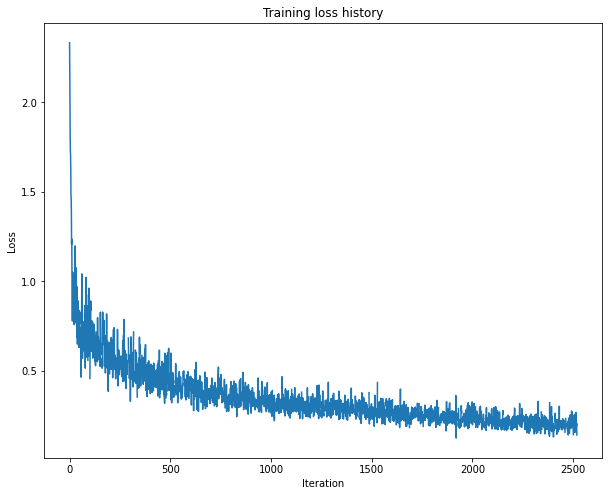

In [155]:
# monitor the training loss
torch.autograd.set_detect_anomaly(True)
fix_random_seed(0)

for lr in [1e-2]:
  print('lr: ', lr)
  yolo_detector = SingleStageDetector()
  loss_history_overfit = DetectionSolver(yolo_detector, train_loader, learning_rate=lr, num_epochs=20)

After you are done with the problem set, delete the above cell since it will take up a lot of pages during the PDF conversion due to printing loss every iteration. To see your final loss and the loss curve, we add an additional cell at the bottom which you will keep instead of the cell above.

Final loss obtained is: 0.1421


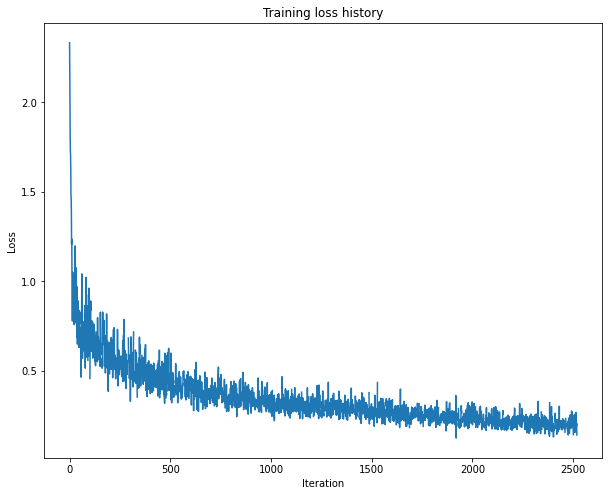

In [156]:
print('Final loss obtained is: %.4f' %(loss_history_overfit[-1]))
plt.plot(loss_history_overfit)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

Run the cell below to save the checkpoint of the trained model and save it to your local system. You can then upload the model and load checkpoint later to colab incase you don't want to run training again.

In [157]:
PATH = 'drive/My Drive/ProjectX 2020/Spatial SR/pytorch-YOLO'

torch.save(yolo_detector.state_dict(), f'{PATH}/yolo_detector_LR_8x.pt') # uncomment to save your checkpoint

# Evaluation

## Inference

Now, implement the inference part of module `SingleStageDetector`.

In [158]:
def detector_inference(self, images, thresh=0.5, nms_thresh=0.7):
  """"
  Inference-time forward pass for the single stage detector.

  Inputs:
  - images: Input images
  - thresh: Threshold value on confidence scores
  - nms_thresh: Threshold value on NMS

  Outputs:
  - final_proposals: Keeped proposals after confidence score thresholding and NMS,
                    a list of B (*x4) tensors
  - final_conf_scores: Corresponding confidence scores, a list of B (*x1) tensors
  - final_class: Corresponding class predictions, a list of B (*x1) tensors
  """
  final_proposals, final_conf_scores, final_class = [], [], []

  # Predicting the final proposal coordinates `final_proposals`,         
  # confidence scores `final_conf_scores`, and the class index `final_class`.  
  
  # The overall steps are similar to the forward pass but now we do not need  
  # to decide the activated nor negative bounding boxes.                         
  # We threshold the conf_scores based on the threshold value `thresh`.  
  # Then, apply NMS (torchvision.ops.nms) to the filtered proposals given the  
  # threshold `nms_thresh`.                                                    
  # The class index is determined by the class with the maximal probability.   
  # Note that `final_propsals`, `final_conf_scores`, and `final_class` are all 
  # lists of B 2-D tensors.

  with torch.no_grad():
    # Feature extraction
    features = self.feat_extractor(images)

    # Grid Generator
    grid_list = GenerateGrid(images.shape[0])

    # Prediction Network
    offsets, conf_scores, class_scores = self.pred_network(features)
    B, A, _, H, W = offsets.shape # (B, A, 4, H, W)
    C = self.num_classes
    conf_scores = conf_scores.reshape(B, -1) # (B, AHW)
    offsets = offsets.permute(0, 1, 3, 4, 2) # (B, A, H, W, 4)
    class_scores = class_scores.permute(0, 2, 3, 1).reshape(B, -1, C) # (B, H*W, C)

    most_conf_class_score, most_conf_class_idx = class_scores.max(dim=-1)

    # Proposal generator
    proposals = GenerateProposal(grid_list, offsets).reshape(B, -1, 4) # (B, AHW, 4)

    # Thresholding and NMS
    for i in range(B):
      score_mask = torch.nonzero((conf_scores[i] > thresh)).squeeze(1) # (AxH'xW')
      
      prop_before_nms = proposals[i, score_mask]
      scores_before_nms = conf_scores[i, score_mask]
      class_idx_before_nms = most_conf_class_idx[i, score_mask%(H*W)]
      # class_prob_before_nms = most_conf_class_prob[i, score_mask/A]

      prop_keep = torchvision.ops.nms(prop_before_nms, scores_before_nms, nms_thresh).to(images.device)
      final_proposals.append(prop_before_nms[prop_keep])
      final_conf_scores.append(scores_before_nms[prop_keep].unsqueeze(-1))
      final_class.append(class_idx_before_nms[prop_keep].unsqueeze(-1))

  return final_proposals, final_conf_scores, final_class

SingleStageDetector.inference = detector_inference

In [159]:
def DetectionInference(detector, data_loader, idx_to_class, thresh=0.8, nms_thresh=0.3, output_dir=None):

  # ship model to GPU
  detector.to(**to_float_cuda)
 
  detector.eval()
  start_t = time.time()

  if output_dir is not None:
    det_dir = 'mAP/input/detection-results'
    gt_dir = 'mAP/input/ground-truth'
    if os.path.exists(det_dir):
      shutil.rmtree(det_dir)
    os.mkdir(det_dir)
    if os.path.exists(gt_dir):
      shutil.rmtree(gt_dir)
    os.mkdir(gt_dir)

  for iter_num, data_batch in enumerate(data_loader):
    images, boxes = data_batch
    images = images.to(**to_float_cuda)

    final_proposals, final_conf_scores, final_class = detector.inference(images, thresh=thresh, nms_thresh=nms_thresh)

    # clamp on the proposal coordinates
    batch_size = len(images)
    for idx in range(batch_size):
      torch.clamp_(final_proposals[idx][:, 0::2], min=0, max=1152)
      torch.clamp_(final_proposals[idx][:, 1::2], min=0, max=768)

      # visualization
      # get the original image
      # hack to get the original image so we don't have to load from local again...
      i = batch_size*iter_num + idx
      img, _ = dataset.__getitem__(i)

      valid_box = sum([1 if j != -1 else 0 for j in boxes[idx][:, 0]])
      final_all = torch.cat((final_proposals[idx], \
        final_class[idx].float(), final_conf_scores[idx]), dim=-1).cpu()
      resized_proposals = coord_trans(final_all)

      # write results to file for evaluation (use mAP API https://github.com/Cartucho/mAP for now...)
      if output_dir is not None:
        file_name = f'{iter_num}_{idx}.txt'
        with open(os.path.join(det_dir, file_name), 'w') as f_det, \
          open(os.path.join(gt_dir, file_name), 'w') as f_gt:
          print('{}: {} GT bboxes and {} proposals'.format(f'{iter_num}_{idx}.txt', valid_box, resized_proposals.shape[0]))
          for b in boxes[idx][:valid_box]:
            f_gt.write('{} {:.2f} {:.2f} {:.2f} {:.2f}\n'.format(idx_to_class[int(b[4])], int(b[0]), int(b[1]), int(b[2]), int(b[3])))
          for b in resized_proposals:
            f_det.write('{} {:.6f} {:.2f} {:.2f} {:.2f} {:.2f}\n'.format(idx_to_class[int(b[4])], b[5], int(b[0]), int(b[1]), int(b[2]), int(b[3])))
      else:
        for i in range(3):
          data_visualizer(img[i], idx_to_class, boxes[idx][:valid_box], resized_proposals)

  end_t = time.time()
  print('Total inference time: {:.1f}s'.format(end_t-start_t))

### Inference: Sanity Check on Training Data


In [161]:
num_sample = 10
small_dataset = torch.utils.data.Subset(train_dataset, torch.linspace(0, len(train_dataset)-1, steps=num_sample).long())
small_train_loader = extreme_weather_loader(small_dataset, 10, 0, True) # a new loader

# visualize the same output from the model trained on the entire training set
# some bounding boxes might not make sense
DetectionInference(yolo_detector, small_train_loader, idx_to_class)

Output hidden; open in https://colab.research.google.com to view.

## Calculate Mean Average Precision (mAP)
Compute mean Average Precision (mAP). Introduction on mAP see [lecture slides](https://www.eecs.umich.edu/courses/eecs442-ahowens/fa20/lec/lec12-object.pdf) (p42-47) or the [repository](https://github.com/Cartucho/mAP) 


Run the following to evaluate your detector on the PASCAL VOC validation set. You should see mAP at around 12% or above.

The state of the art on this dataset is >80% mAP! To achieve these results we would need to use a much bigger network, and train with more data and for much longer, but that is beyond the scope of this problem set.

(Optional) If you train the model longer (e.g., 100 epochs), you should see a better mAP. But make sure you revert the code back for grading purposes.

In [162]:
DetectionInference(yolo_detector, val_loader, idx_to_class, output_dir='mAP/input', thresh=0.8, nms_thresh=0.3)
# DetectionInference(yolo_detector, train_loader, train_dataset, idx_to_class, output_dir='mAP/input', thresh=0.8, nms_thresh=0.3) # uncomment to see training mAP
!cd mAP && python main.py

0_0.txt: 8 GT bboxes and 56 proposals
0_1.txt: 7 GT bboxes and 81 proposals
0_2.txt: 6 GT bboxes and 71 proposals
0_3.txt: 6 GT bboxes and 61 proposals
0_4.txt: 7 GT bboxes and 55 proposals
0_5.txt: 7 GT bboxes and 66 proposals
0_6.txt: 8 GT bboxes and 40 proposals
0_7.txt: 8 GT bboxes and 57 proposals
0_8.txt: 8 GT bboxes and 39 proposals
0_9.txt: 6 GT bboxes and 44 proposals
1_0.txt: 6 GT bboxes and 53 proposals
1_1.txt: 6 GT bboxes and 61 proposals
1_2.txt: 5 GT bboxes and 52 proposals
1_3.txt: 5 GT bboxes and 39 proposals
1_4.txt: 4 GT bboxes and 61 proposals
1_5.txt: 4 GT bboxes and 45 proposals
1_6.txt: 5 GT bboxes and 59 proposals
1_7.txt: 5 GT bboxes and 46 proposals
1_8.txt: 5 GT bboxes and 54 proposals
1_9.txt: 7 GT bboxes and 30 proposals
2_0.txt: 7 GT bboxes and 47 proposals
2_1.txt: 6 GT bboxes and 55 proposals
2_2.txt: 7 GT bboxes and 32 proposals
2_3.txt: 8 GT bboxes and 40 proposals
2_4.txt: 8 GT bboxes and 40 proposals
2_5.txt: 8 GT bboxes and 61 proposals
2_6.txt: 6 G

Final mAP obtained on the validation set


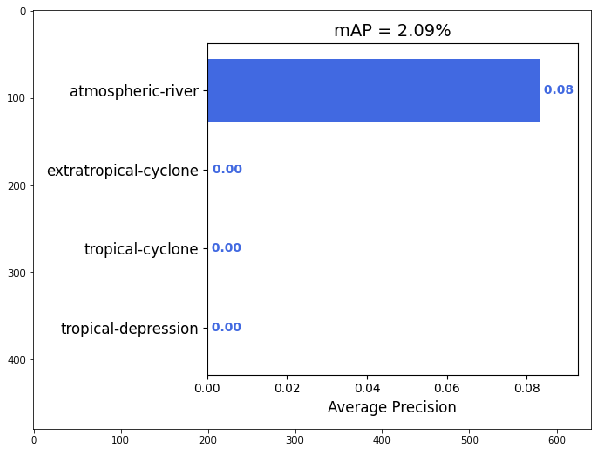

In [163]:
from PIL import Image
img = Image.open('mAP/output/mAP.png')
print('Final mAP obtained on the validation set')
plt.imshow(img)
% mv mAP/output/mAP.png 'drive/My Drive/ProjectX 2020/Spatial SR/pytorch-YOLO/figures/mAP-LR-8x.png'